# Water level Bottle image Classification

# Your proposed models should reach atleast at  80% of accuracy

### Imported libraries

This starter code version for tensor flow however you are allowed to implement similar approach using any other libraries

In [1]:
# Import necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import logging
import numpy as np
import zipfile
import os

# Set up logging to capture TensorFlow warnings and errors
logging.basicConfig(level=logging.ERROR, filename='tensorflow.log', filemode='w')


2024-03-09 17:06:20.980548: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 17:06:20.980597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 17:06:20.982263: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Set all parameters

In [2]:
BATCH_SIZE = 32       # How many images to be included in each batch.
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 60

In [3]:
# Extract the contents of the zip file
# with zipfile.ZipFile("/content/drive/MyDrive/Water_Bottle_Image_Dataset.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive/Water_Bottle_Image_Dataset")

# The directory path containing the extracted images
dataset_directory = "/kaggle/input/water-bottle-image-dataset-1/Water_Bottle_Image_Dataset/"

### Import data into tensorflow dataset object

In [4]:
#enter your code here
# Now use image_dataset_from_directory with the correct directory path
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_directory,
    seed=123,                                   # It is used to shuffle the dataset, same seed will produce the same shuffling order each time.
    shuffle=True,                               # Specify to shuffle the dataset. Helps to prevent the model from learning the order of the data.

    # Pre-processing 1: Images to be resized (W:256, H:256) during pre-processing.
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 486 files belonging to 3 classes.


In [5]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
class_names = dataset.class_names
class_names

['Full  Water level', 'Half water level', 'Overflowing']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 1 0 2 2 0 0 1 1 0 1 0 0 0 1 0 0 2 0 0 1 1 0 1 0 0 0 1 0]


### Visualize some of the images from our dataset

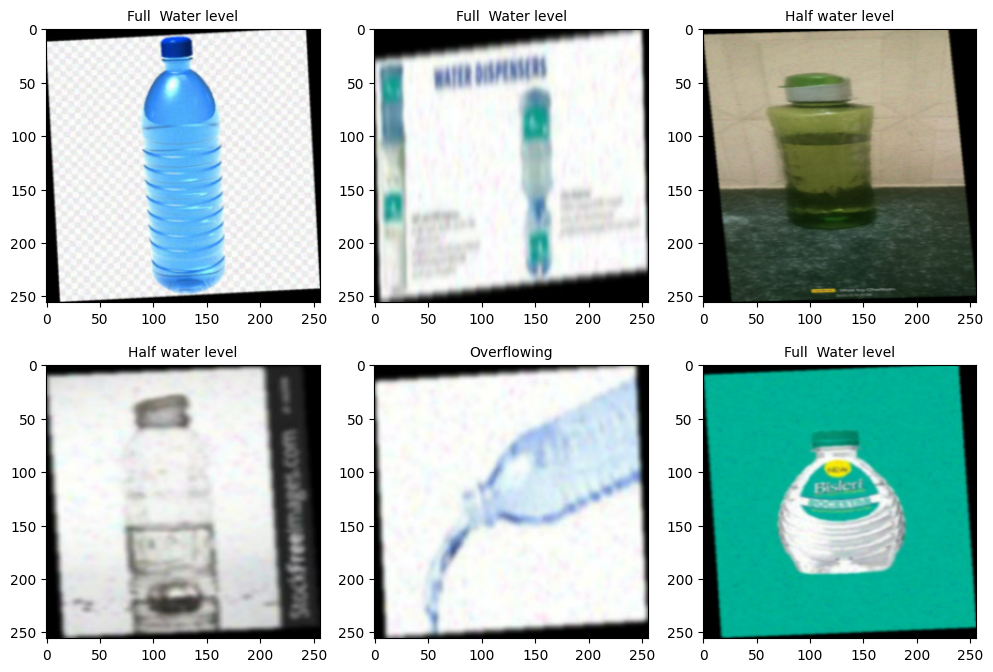

In [8]:
num_rows = 2
num_cols = 3

# A grid of subplots with num_rows = 2 and num_cols = 3. Figsize = (12, 8)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12,8))

axes = axes.flatten()

for image_batch, labels_batch in dataset.take(1):
  for i in range(6):
    # Convert the tensor object to numpy array
    image_batch_array = image_batch[i].numpy().astype("uint8")

    # Get the class name.
    image_batch_label = class_names[labels_batch[i]]
    axes[i].imshow(image_batch_array)
    axes[i].set_title(image_batch_label, fontsize = 10)

plt.show()


### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [9]:
len(dataset)

16

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.75, val_split=0.125, test_split=0.125, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    # Check if the shuffle variable is True.
    if shuffle:
      ds = ds.shuffle(buffer_size=1000, seed = 12)

    # Based on the split ratio, calculate the train data size.
    train_size = train_split * ds_size
    train_size = int(train_size)    # Convert to integer the floating point number
    train_ds = ds.take(train_size)

    # Based on the split ratio, calculate the validation data size.
    val_size = val_split * ds_size
    val_size = int(val_size)        # Convert to integer the floating point number
    val_ds = ds.skip(train_size).take(val_size)

    # Based on the split ratio, calculate the test data size.
    test_size = test_split * ds_size
    test_size = int(test_size)    # Convert to integer the floating point number
    test_ds = ds.skip(train_size).skip(val_size).take(test_size)

    #split the data into validation,training and test dataset
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
print(f" Length of training dataset: {len(train_ds)}\n Length of validation dataset: {len(val_ds)}\n Length of test dataset: {len(test_ds)}")

 Length of training dataset: 12
 Length of validation dataset: 2
 Length of test dataset: 2


### Cache, Shuffle, and Prefetch the Dataset

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before you feed your images to network, you would be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).

In [14]:
#resize_and_rescale

class ResizeNormalizeLayer(tf.keras.layers.Layer):
  def __init__(self, target_size):
     super(ResizeNormalizeLayer, self).__init__()
     self.target_size = target_size

  def call(self, inputs):
    resized_images = tf.image.resize(inputs, self.target_size)
    # Normalize pixel values to [0, 1]
    normalized_images = resized_images / 255.0
    return normalized_images

resize_and_rescale = tf.keras.Sequential([
    ResizeNormalizeLayer(target_size=(IMAGE_SIZE, IMAGE_SIZE))
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [15]:
#compute data augmentation
data_augmentation = tf.keras.Sequential([
  layers.GaussianNoise(0.01),
  layers.RandomRotation(0.3),                      # Randomly rotate images by up to 3 degrees.
  layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically.
  layers.RandomContrast(0.2),                    # Randomly adjust contrast of images by up to 20%
])

#### Applying Data Augmentation to Train Dataset

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
We use a CNN coupled with your chosen activation function in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [17]:
#implement your architecture here
def create_model(input_shape, num_classes):

  model = models.Sequential([
      resize_and_rescale,

      # 1st convolution layer
      layers.Conv2D(32, kernel_size = (3, 3), activation = "relu", input_shape =  input_shape),
      layers.MaxPooling2D((2,2)),

      # 2nd convolutional layer
      layers.Conv2D(64, kernel_size = (3, 3), activation = "relu"),
      layers.MaxPooling2D((2,2)),

      # 3rd convolutional layer
      layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
      layers.MaxPooling2D((2,2)),

      # 4th convolutional layer
      layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
      layers.MaxPooling2D((2,2)),

      # 5th convolutional layer
      layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
      layers.MaxPooling2D((2,2)),

      # Flatten the output of the convolution layers...
      layers.Flatten(),

      # Fully connected layers...
      layers.Dense(64, activation = "relu"),

      # Output layer with softmax activation for classification
      layers.Dense(num_classes, activation = "softmax")
  ])

  model.build(input_shape = input_shape)

  return model

input_shape = image_batch.shape
num_classes = len(class_names)

# Create the model
model = create_model(input_shape, num_classes)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [18]:
# Model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Compiling the Model**
- Use optimizer, losses, and your desired metric (accuracy)

In [19]:
#model.compile()
# Adam combines the ideas of momentum and RMSProp.
# It converges quickly and performs well on a variety of tasks without requiring fine-tuning of hyperparameters.
model.compile(optimizer="adam", \
              loss = "sparse_categorical_crossentropy", \
              metrics = ["accuracy"]
              )

**Fit the Model**

In [20]:
#fit your model
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS,
)

Epoch 1/60


2024-03-09 17:06:50.006628: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 5.22285, expected 4.50617
2024-03-09 17:06:50.006693: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19: 4.83523, expected 4.11855
2024-03-09 17:06:50.006703: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 20: 6.14347, expected 5.42679
2024-03-09 17:06:50.006711: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21: 5.72417, expected 5.00749
2024-03-09 17:06:50.006719: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 6.00776, expected 5.29109
2024-03-09 17:06:50.006727: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 5.39609, expected 4.67941
2024-03-09 17:06:50.006736: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 5.14673, expected 4.43005
2024-03-09 17:06:50.006744: E external/local_xla/

 1/12 ━━━━━━━━━━━━━━━━━━━━ 2:17 12s/step - accuracy: 0.1562 - loss: 1.0879

I0000 00:00:1710004016.579445     511 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710004016.596123     511 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 700ms/step - accuracy: 0.5386 - loss: 0.9152 - val_accuracy: 0.6719 - val_loss: 0.8610
Epoch 2/60


W0000 00:00:1710004024.285735     512 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - accuracy: 0.6728 - loss: 0.8549 - val_accuracy: 0.6719 - val_loss: 0.7683
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step - accuracy: 0.6780 - loss: 0.7798 - val_accuracy: 0.6719 - val_loss: 0.7669
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 470ms/step - accuracy: 0.6530 - loss: 0.7891 - val_accuracy: 0.6719 - val_loss: 0.7350
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 491ms/step - accuracy: 0.6452 - loss: 0.8254 - val_accuracy: 0.6719 - val_loss: 0.7834
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 468ms/step - accuracy: 0.6203 - loss: 0.8673 - val_accuracy: 0.6719 - val_loss: 0.7504
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 463ms/step - accuracy: 0.6425 - loss: 0.8025 - val_accuracy: 0.6719 - val_loss: 0.7298
Epoch 8/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - accuracy: 0.6555 - loss: 0.7825 - val_accuracy: 0.6719 - val_loss: 0.7297
Epoch 9/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 464ms/step - accuracy: 0.6614 - loss: 0.7628 - val_accuracy: 0.6719 - val_

**Compute model evaluation**

In [21]:
scores = model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8229 - loss: 0.7265


In [22]:
scores

[0.8043009638786316, 0.84375]

**Plotting the Accuracy and Loss Curves**




In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 60, 'steps': 12}

In [25]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**Evaluation metrics from history**
- Loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [26]:
#get your evaluation metrics from history
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
train_loss = history.history["loss"]

**Graphical Plot:**
- Plot of Training Accuracy against Validation Accuracy

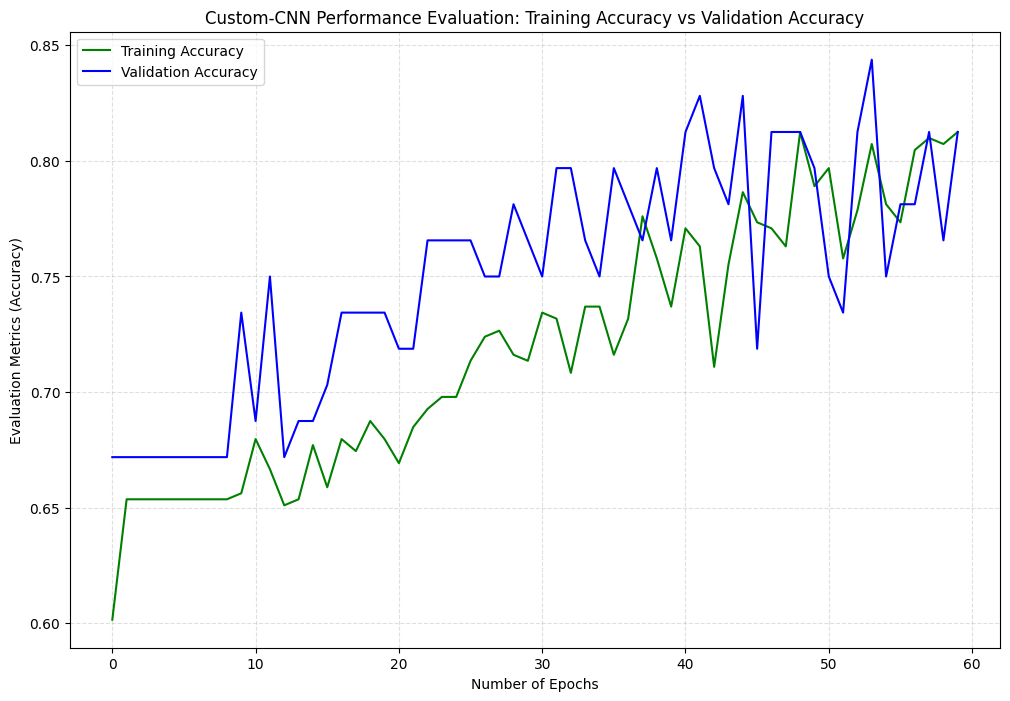

<Figure size 640x480 with 0 Axes>

In [27]:
plt.figure(figsize=(12,8))
plt.plot(range(EPOCHS), train_accuracy, color="green", label="Training Accuracy")
plt.plot(range(EPOCHS), val_accuracy, color="blue", label = "Validation Accuracy")
plt.title("Custom-CNN Performance Evaluation: Training Accuracy vs Validation Accuracy")
plt.ylabel("Evaluation Metrics (Accuracy)")
plt.xlabel("Number of Epochs")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="best")
plt.show()

#save the plot.
plt.savefig('custom_cnn_accuracy.png')

**Graphical Plot:**
- Plot of Training Loss against Validation Loss

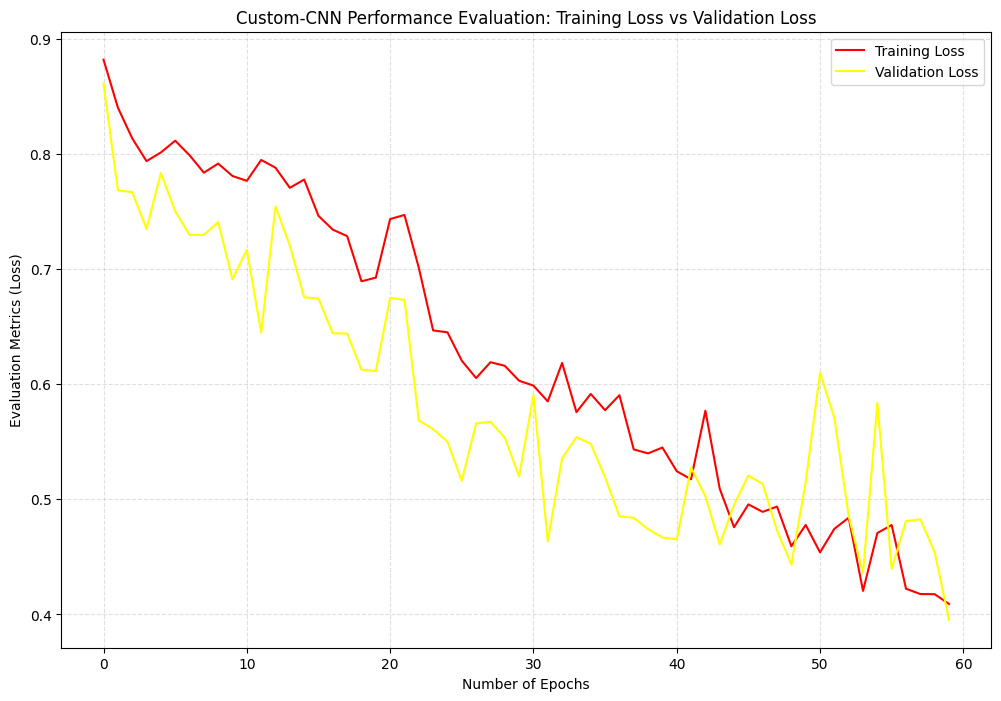

<Figure size 640x480 with 0 Axes>

In [28]:
plt.figure(figsize=(12,8))
plt.plot(range(EPOCHS), train_loss, color="red", label="Training Loss")
plt.plot(range(EPOCHS), val_loss, color="yellow", label = "Validation Loss")
plt.title("Custom-CNN Performance Evaluation: Training Loss vs Validation Loss")
plt.ylabel("Evaluation Metrics (Loss)")
plt.xlabel("Number of Epochs")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="best")
plt.show()

#save the plot.
plt.savefig('custom_cnn_loss.png')

**Run prediction on a sample image**

first image to predict
actual label: Full  Water level
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


W0000 00:00:1710004368.359487     510 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


predicted label: Full  Water level


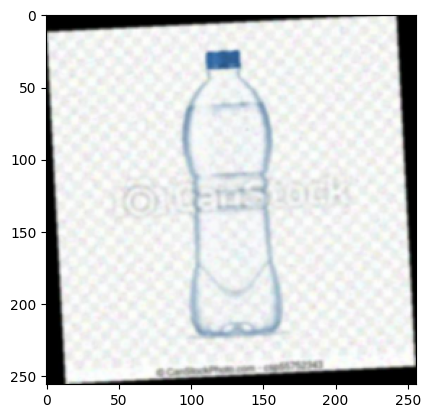

In [29]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**Write a function for inference**

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

2024-03-09 17:12:49.230246: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 387127: 5.77154, expected 5.03187
2024-03-09 17:12:49.230314: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 387168: 6.05753, expected 5.31786
2024-03-09 17:12:49.230334: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 387274: 5.79451, expected 5.05483
2024-03-09 17:12:49.230354: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 387303: 6.3865, expected 5.64683
2024-03-09 17:12:49.230370: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 387310: 6.3852, expected 5.64553
2024-03-09 17:12:49.230382: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 387370: 6.37416, expected 5.63449
2024-03-09 17:12:49.230394: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 387381: 4.72788, expected 3.98821
2024-03-09 17:12:49.23

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


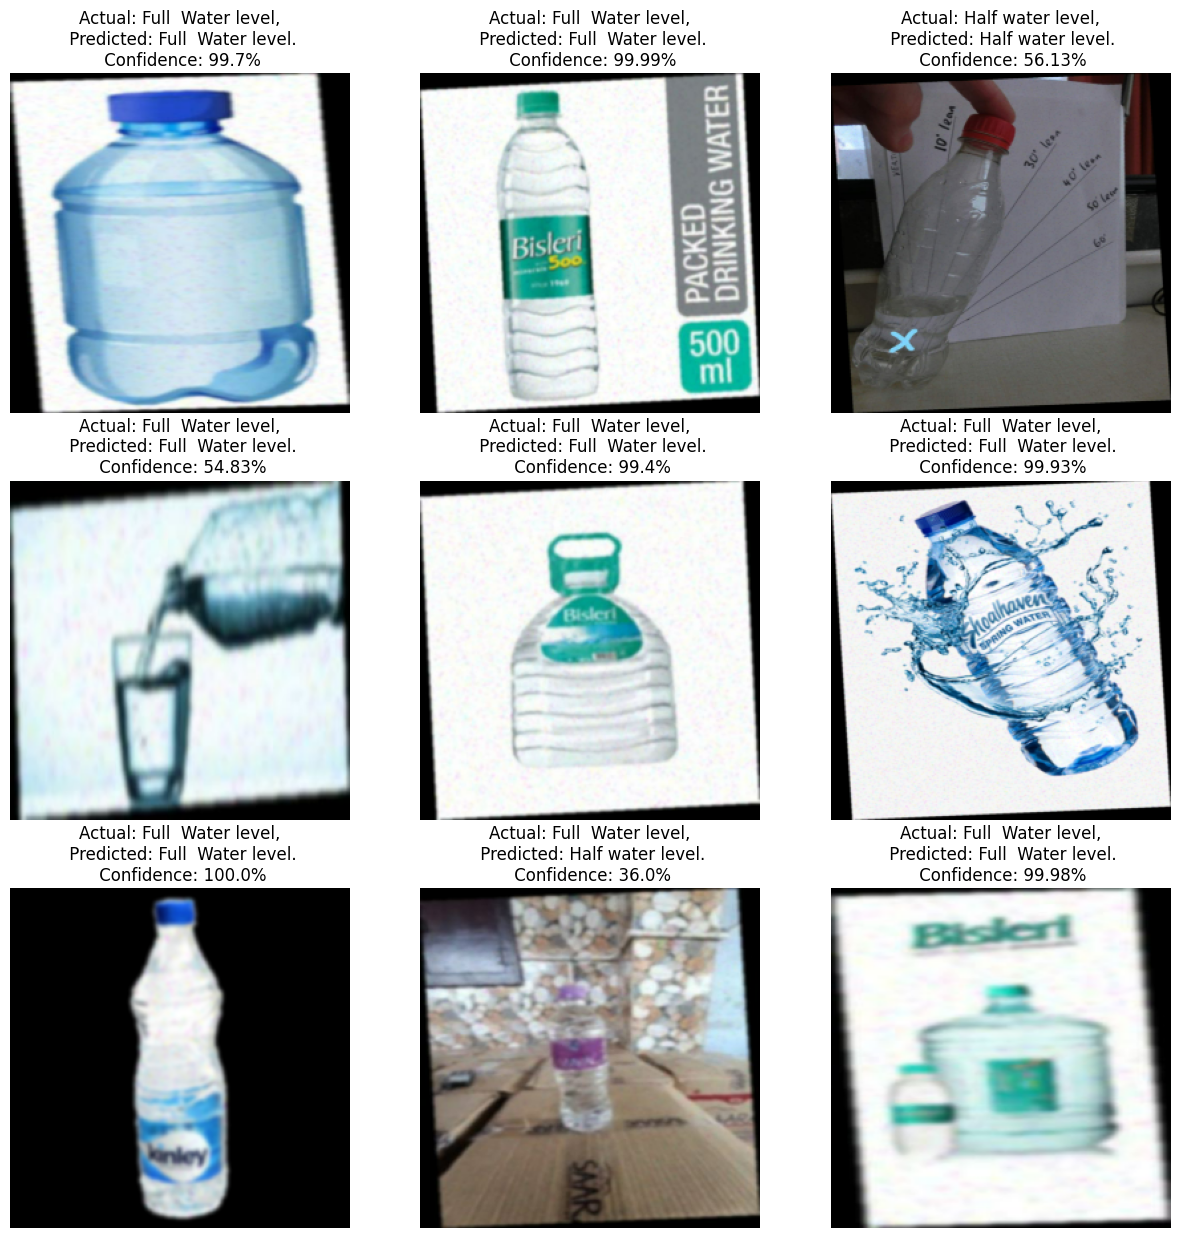

In [31]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [32]:
# Print dataset details
print("Dataset details:")
print("Number of classes:", len(class_names))
print("Class names:", class_names)
print("Number of training examples:", tf.data.Dataset.cardinality(train_ds))
print("Number of validation examples:", tf.data.Dataset.cardinality(val_ds))
print("Number of test examples:", tf.data.Dataset.cardinality(test_ds))

# Print model details
print("Model details:")
print("Input shape:", input_shape)
# print("Output shape:", model.output_shape)
print("Number of layers:", len(model.layers))


Dataset details:
Number of classes: 3
Class names: ['Full  Water level', 'Half water level', 'Overflowing']
Number of training examples: tf.Tensor(12, shape=(), dtype=int64)
Number of validation examples: tf.Tensor(2, shape=(), dtype=int64)
Number of test examples: tf.Tensor(2, shape=(), dtype=int64)
Model details:
Input shape: (32, 256, 256, 3)
Number of layers: 14


# **Practice with Other Architecture:**
- Choose other known architecture and compare the result you are getting in report

# **1. AlexNet Model Architecture**

In [33]:
# Parameters
input_shape = image_batch.shape
num_classes = len(class_names)

def alexnet(input_shape, num_classes):
  model = models.Sequential([
      resize_and_rescale,

      # 1st Convolution layer
      layers.Conv2D(96, kernel_size = (11, 11), strides=(4, 4), activation="relu", input_shape=input_shape),
      layers.BatchNormalization(),
      layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

      # 2nd Convolution layer
      layers.Conv2D(256, kernel_size=(5,5), padding="same", activation="relu"),
      layers.BatchNormalization(),
      layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

      # 3rd Convolution layer
      layers.Conv2D(384, kernel_size=(3,3), padding="same", activation="relu"),
      layers.BatchNormalization(),

      # 4th Convolution layer
      layers.Conv2D(384, kernel_size=(3,3), padding="same", activation="relu"),
      layers.BatchNormalization(),

      # 5th Convolution layer
      layers.Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"),
      layers.BatchNormalization(),
      layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

      # Flatten the output of the convolution layers
      layers.Flatten(),

      # 1st Dense layer
      layers.Dense(4096, activation="relu"),
      layers.Dropout(0.5),

      # 2nd Dense layer
      layers.Dense(4096, activation="relu"),
      layers.Dropout(0.5),

      # Output layer
      layers.Dense(num_classes, activation="softmax")
  ])

  model.build(input_shape=input_shape)

  return model

# Create AlexNet model
model =  alexnet(input_shape, num_classes)

# Print the model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Compiling the Model**
- Use optimizer, losses, and your desired metric (accuracy)

In [34]:
#model.compile()
model.compile(optimizer="adam", \
              loss = "sparse_categorical_crossentropy", \
              metrics = ["accuracy"]
              )

**Fit the Model**

In [35]:
#fit your model
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS,
)

Epoch 1/60
 1/12 ━━━━━━━━━━━━━━━━━━━━ 3:26 19s/step - accuracy: 0.1875 - loss: 3.2769

W0000 00:00:1710004390.961353     510 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 514ms/step - accuracy: 0.4754 - loss: 32.9016 - val_accuracy: 0.6719 - val_loss: 227.9000
Epoch 2/60


W0000 00:00:1710004396.618464     512 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - accuracy: 0.5884 - loss: 7.2842 - val_accuracy: 0.6719 - val_loss: 745.2875
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step - accuracy: 0.5395 - loss: 4.5478 - val_accuracy: 0.6719 - val_loss: 272.5222
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 469ms/step - accuracy: 0.6580 - loss: 3.0616 - val_accuracy: 0.6562 - val_loss: 35.2297
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 479ms/step - accuracy: 0.6069 - loss: 1.9834 - val_accuracy: 0.6719 - val_loss: 61.7183
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.6074 - loss: 1.8599 - val_accuracy: 0.6562 - val_loss: 30.7546
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - accuracy: 0.6023 - loss: 1.5950 - val_accuracy: 0.6406 - val_loss: 15.7930
Epoch 8/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 477ms/step - accuracy: 0.6273 - loss: 1.2741 - val_accuracy: 0.6719 - val_loss: 3.8033
Epoch 9/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step - accuracy: 0.6676 - loss: 1.7845 - val_accuracy: 0.703

## **Compute model evaluation**

In [36]:
scores = model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6354 - loss: 0.6633


In [37]:
scores

[0.6499793529510498, 0.640625]

In [38]:
history

In [39]:
history.params

{'verbose': 1, 'epochs': 60, 'steps': 12}

In [40]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**Evaluation metrics from history**
- Loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [41]:
#get your evaluation metrics from history
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
train_loss = history.history["loss"]

**Graphical Plot:**
- Plot of Training Accuracy against Validation Accuracy

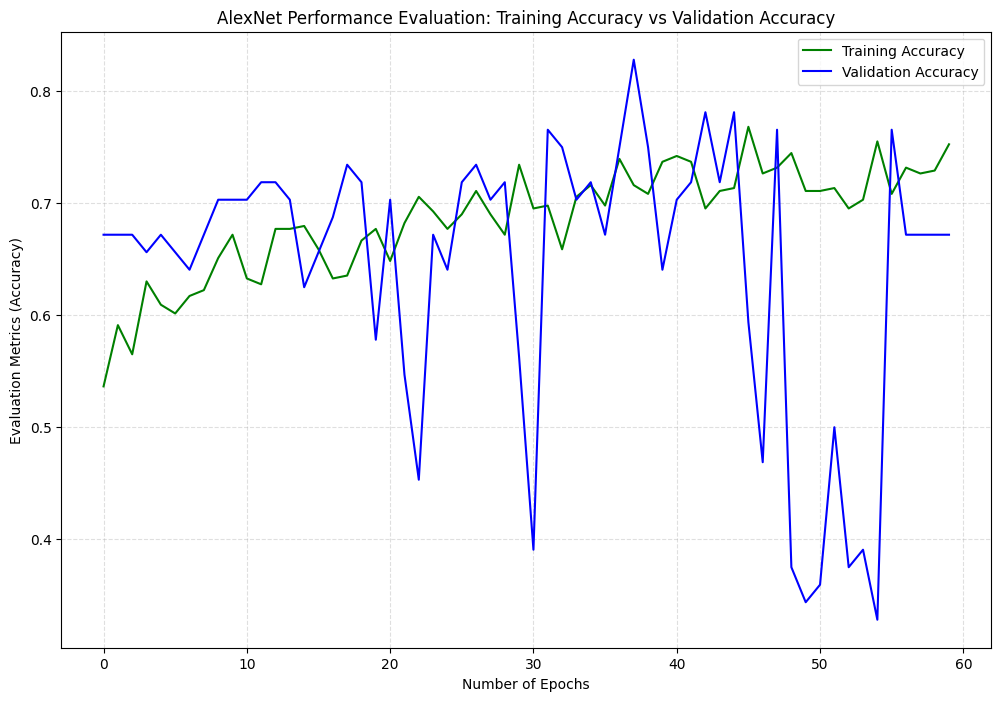

<Figure size 640x480 with 0 Axes>

In [42]:
plt.figure(figsize=(12,8))
plt.plot(range(EPOCHS), train_accuracy, color="green", label="Training Accuracy")
plt.plot(range(EPOCHS), val_accuracy, color="blue", label = "Validation Accuracy")
plt.title("AlexNet Performance Evaluation: Training Accuracy vs Validation Accuracy")
plt.ylabel("Evaluation Metrics (Accuracy)")
plt.xlabel("Number of Epochs")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="best")
plt.show()

#save the plot.
plt.savefig('alexnet_accuracy.png')

**Graphical Plot:**
- Plot of Training Loss against Validation Loss

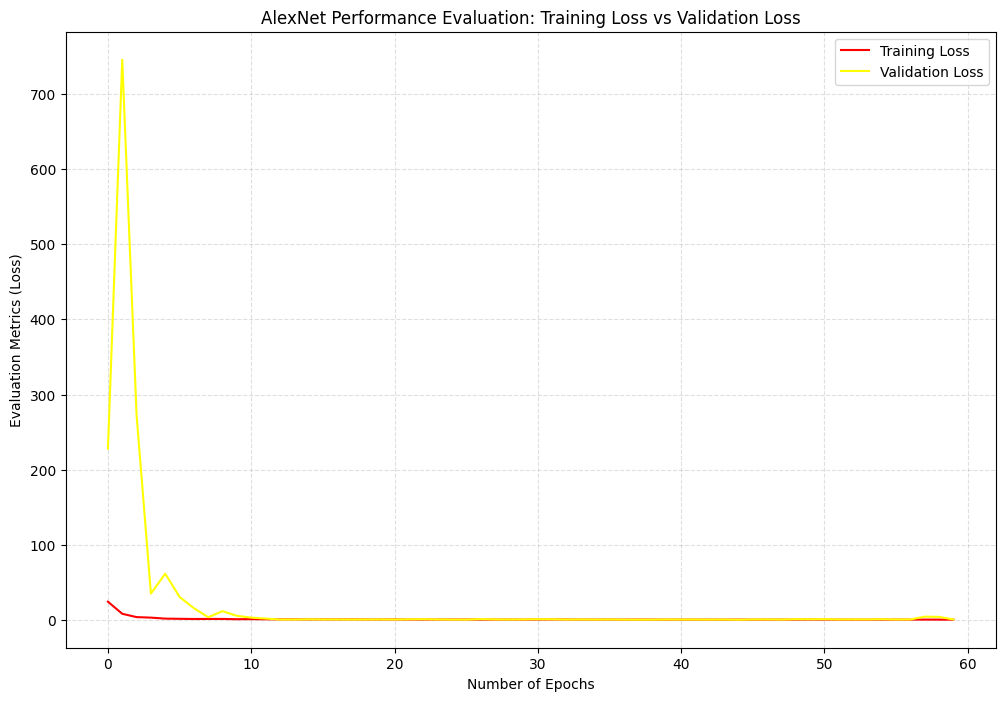

<Figure size 640x480 with 0 Axes>

In [43]:
plt.figure(figsize=(12,8))
plt.plot(range(EPOCHS), train_loss, color="red", label="Training Loss")
plt.plot(range(EPOCHS), val_loss, color="yellow", label = "Validation Loss")
plt.title("AlexNet Performance Evaluation: Training Loss vs Validation Loss")
plt.ylabel("Evaluation Metrics (Loss)")
plt.xlabel("Number of Epochs")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="best")
plt.show()

#save the plot.
plt.savefig('alex_net_loss.png')

**Run prediction on a sample image**

first image to predict
actual label: Full  Water level
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


W0000 00:00:1710004740.332703     513 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


predicted label: Half water level


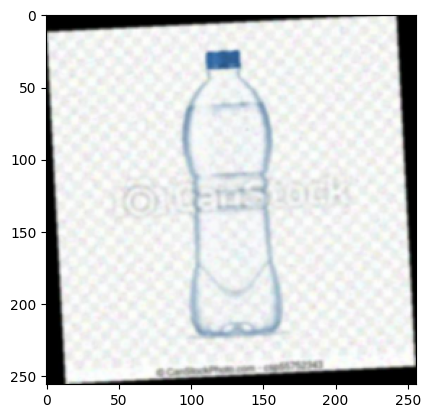

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**Write a function for inference**

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


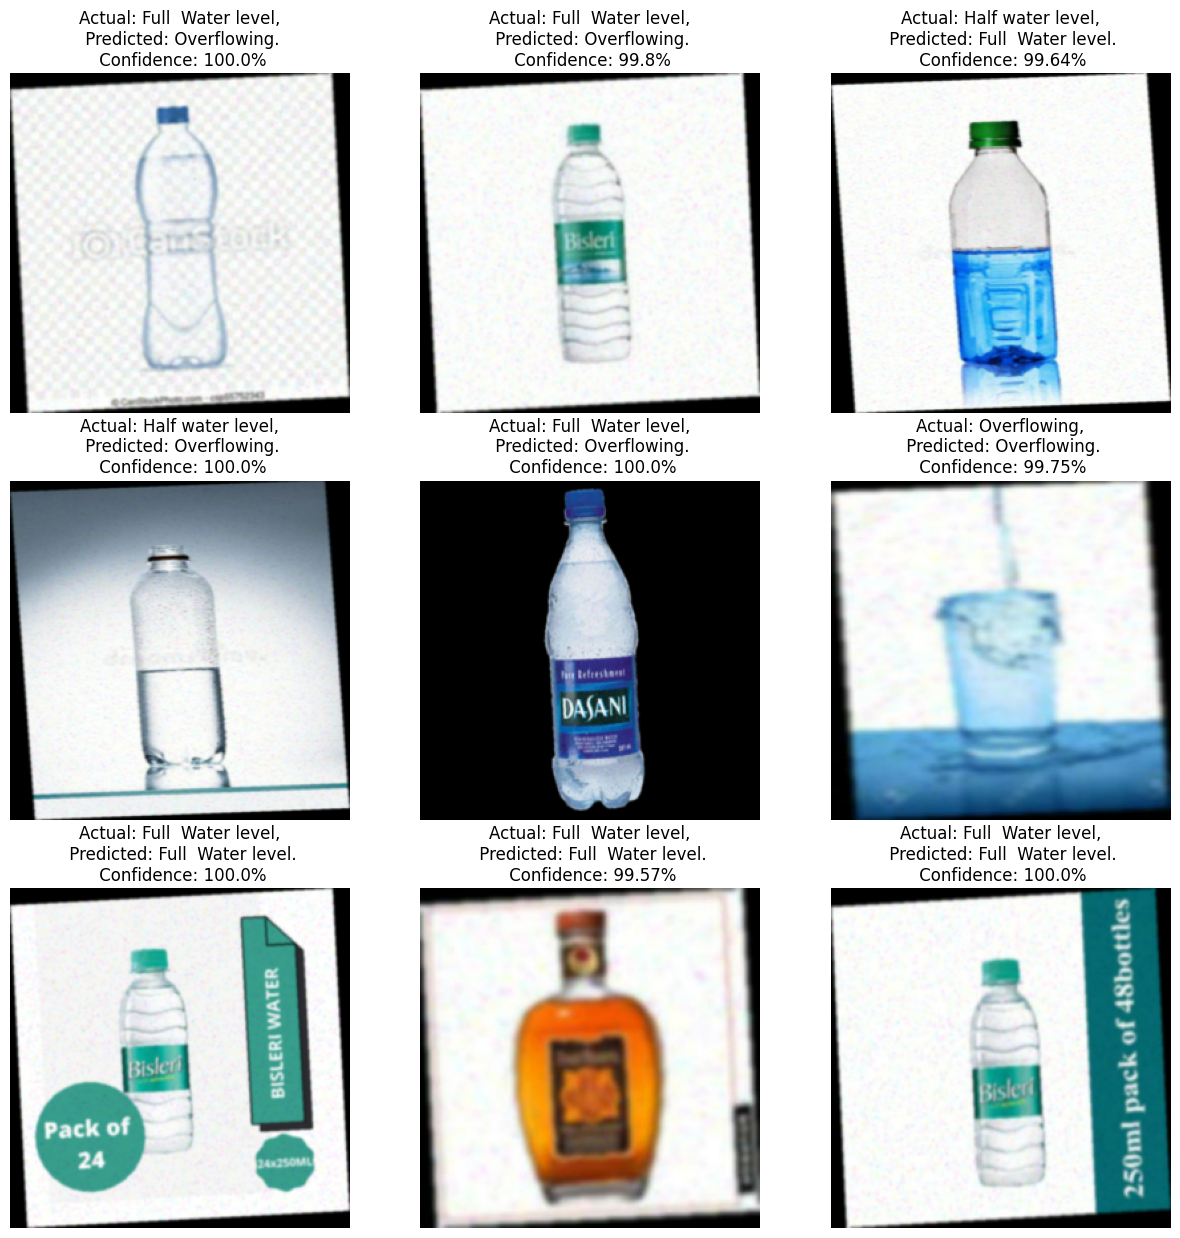

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# **VGG-16 Model Architecture**

In [47]:
#resize_and_rescale

class ResizeNormalizeLayer(tf.keras.layers.Layer):
  def __init__(self, target_size):
     super(ResizeNormalizeLayer, self).__init__()
     self.target_size = target_size

  def call(self, inputs):
    resized_images = tf.image.resize(inputs, self.target_size)
    # Normalize pixel values to [0, 1]
    normalized_images = resized_images / 255.0
    return normalized_images

resize_and_rescale = tf.keras.Sequential([
    ResizeNormalizeLayer(target_size=(IMAGE_SIZE, IMAGE_SIZE))
])

In [48]:
IMAGE_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
    ResizeNormalizeLayer(target_size=(IMAGE_SIZE, IMAGE_SIZE))
])

In [49]:
input_shape = image_batch.shape
num_classes = len(class_names)

def VGGNet_16(input_shape, num_classes):

    model = Sequential()

    # Preprocessing layer
    model.add(layers.Lambda(resize_and_rescale))

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

        # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.build(input_shape=input_shape)

    return model

# Create VGGNet model
model = VGGNet_16(input_shape, num_classes)

# Print model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Compiling the Model**
- Use Optimizer, losses, and your desired metric (accuracy)




In [50]:
#model.compile()
model.compile(optimizer="adam", \
              loss = "sparse_categorical_crossentropy", \
              metrics = ["accuracy"]
              )

In [51]:
#fit your model
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS,
)

Epoch 1/60


2024-03-09 17:19:18.199512: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-03-09 17:19:18.199575: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-03-09 17:19:18.199585: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-03-09 17:19:18.199594: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-03-09 17:19:18.199603: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-03-09 17:19:18.199611: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-03-09 17:19:18.199619: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-03-09 17:19:18.199627: E external/local_xla/xla/se

12/12 ━━━━━━━━━━━━━━━━━━━━ 57s 569ms/step - accuracy: 0.6440 - loss: 1.0798 - val_accuracy: 0.6719 - val_loss: 1.0484
Epoch 2/60


W0000 00:00:1710004800.896103     510 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 499ms/step - accuracy: 0.6477 - loss: 1.0485 - val_accuracy: 0.6719 - val_loss: 1.0342
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 483ms/step - accuracy: 0.6457 - loss: 1.0361 - val_accuracy: 0.6719 - val_loss: 1.0206
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 487ms/step - accuracy: 0.6515 - loss: 1.0221 - val_accuracy: 0.6719 - val_loss: 1.0078
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 496ms/step - accuracy: 0.6459 - loss: 1.0115 - val_accuracy: 0.6719 - val_loss: 0.9957
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 494ms/step - accuracy: 0.6629 - loss: 0.9946 - val_accuracy: 0.6719 - val_loss: 0.9840
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 487ms/step - accuracy: 0.6723 - loss: 0.9860 - val_accuracy: 0.6719 - val_loss: 0.9733
Epoch 8/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 499ms/step - accuracy: 0.6536 - loss: 0.9785 - val_accuracy: 0.6719 - val_loss: 0.9631
Epoch 9/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 491ms/step - accuracy: 0.6465 - loss: 0.9752 - val_accuracy: 0.6719 - val_

## **Compute model evaluation**

In [52]:
scores = model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6146 - loss: 0.8577


In [53]:
history

In [54]:
history.params

{'verbose': 1, 'epochs': 60, 'steps': 12}

In [55]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [56]:
#get your evaluation metrics from history
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
train_loss = history.history["loss"]

**Graphical Plot:**
- Plot of Training Accuracy against Validation Accuracy

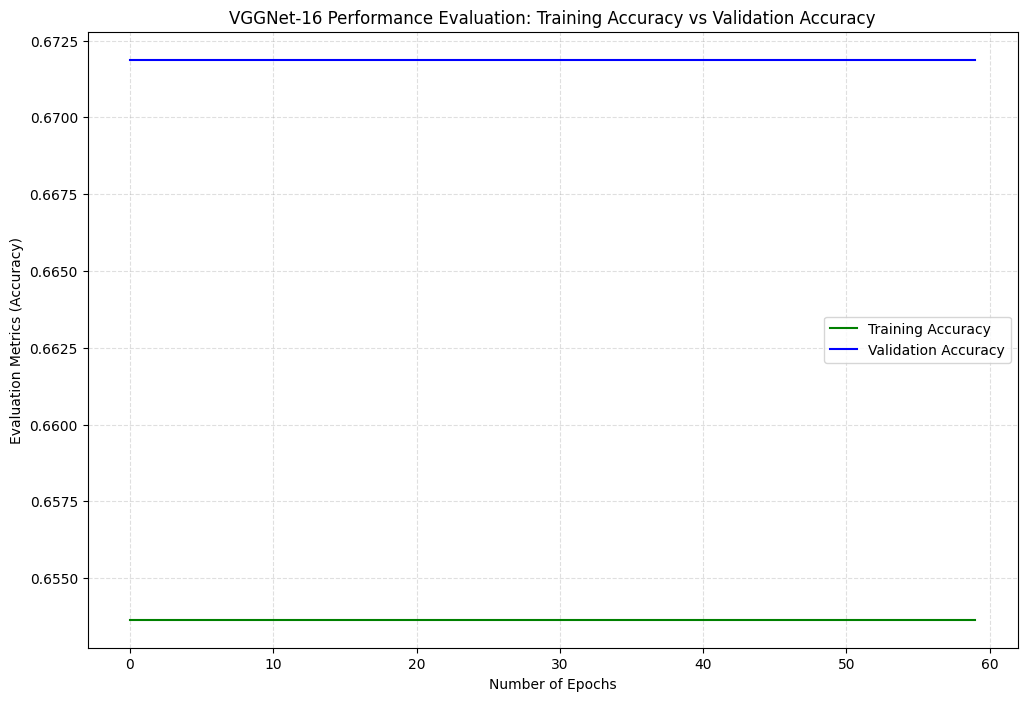

<Figure size 640x480 with 0 Axes>

In [57]:
plt.figure(figsize=(12,8))
plt.plot(range(EPOCHS), train_accuracy, color="green", label="Training Accuracy")
plt.plot(range(EPOCHS), val_accuracy, color="blue", label = "Validation Accuracy")
plt.title("VGGNet-16 Performance Evaluation: Training Accuracy vs Validation Accuracy")
plt.ylabel("Evaluation Metrics (Accuracy)")
plt.xlabel("Number of Epochs")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="best")
plt.show()

#save the plot.
plt.savefig('vggnet_16_accuracy.png')

**Graphical Plot:**
- Plot of Training Loss against Validation Loss

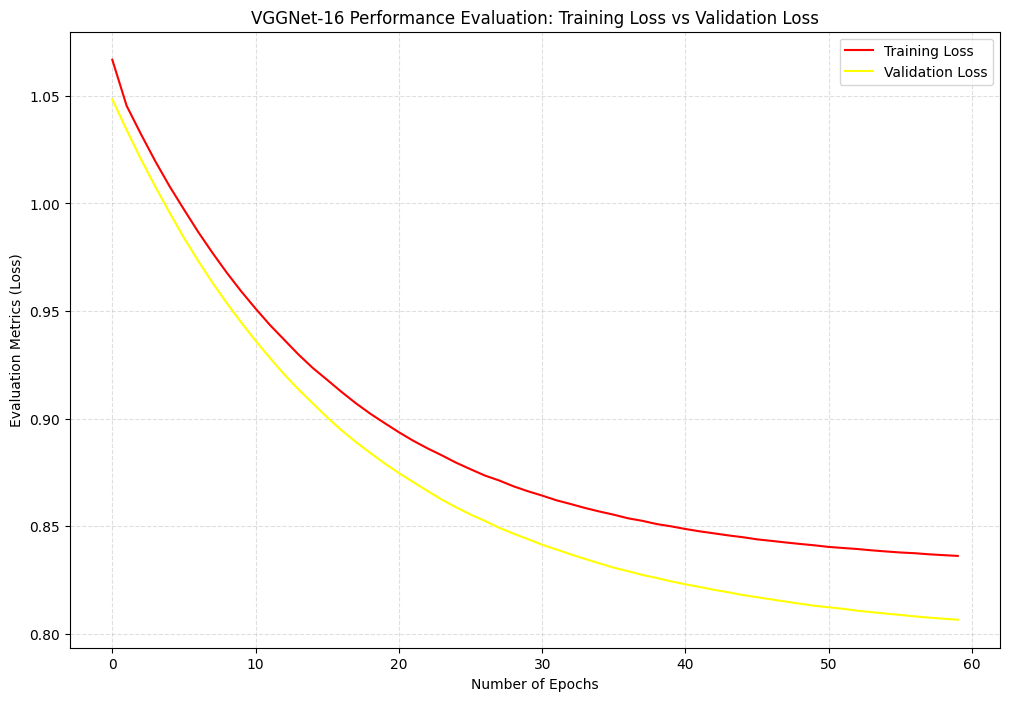

<Figure size 640x480 with 0 Axes>

In [58]:
plt.figure(figsize=(12,8))
plt.plot(range(EPOCHS), train_loss, color="red", label="Training Loss")
plt.plot(range(EPOCHS), val_loss, color="yellow", label = "Validation Loss")
plt.title("VGGNet-16 Performance Evaluation: Training Loss vs Validation Loss")
plt.ylabel("Evaluation Metrics (Loss)")
plt.xlabel("Number of Epochs")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="best")
plt.show()

#save the plot.
plt.savefig('vggnet_16_loss.png')

2024-03-09 17:26:09.118866: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.42855, expected 3.64542
2024-03-09 17:26:09.118925: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.87036, expected 5.08723
2024-03-09 17:26:09.118935: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.04003, expected 5.2569
2024-03-09 17:26:09.118943: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.22034, expected 5.43722
2024-03-09 17:26:09.118952: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.90026, expected 4.11714
2024-03-09 17:26:09.118960: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.21068, expected 4.42756
2024-03-09 17:26:09.118968: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.92061, expected 5.13748
2024-03-09 17:26:09.118976: E external/local_xla/xla/ser

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


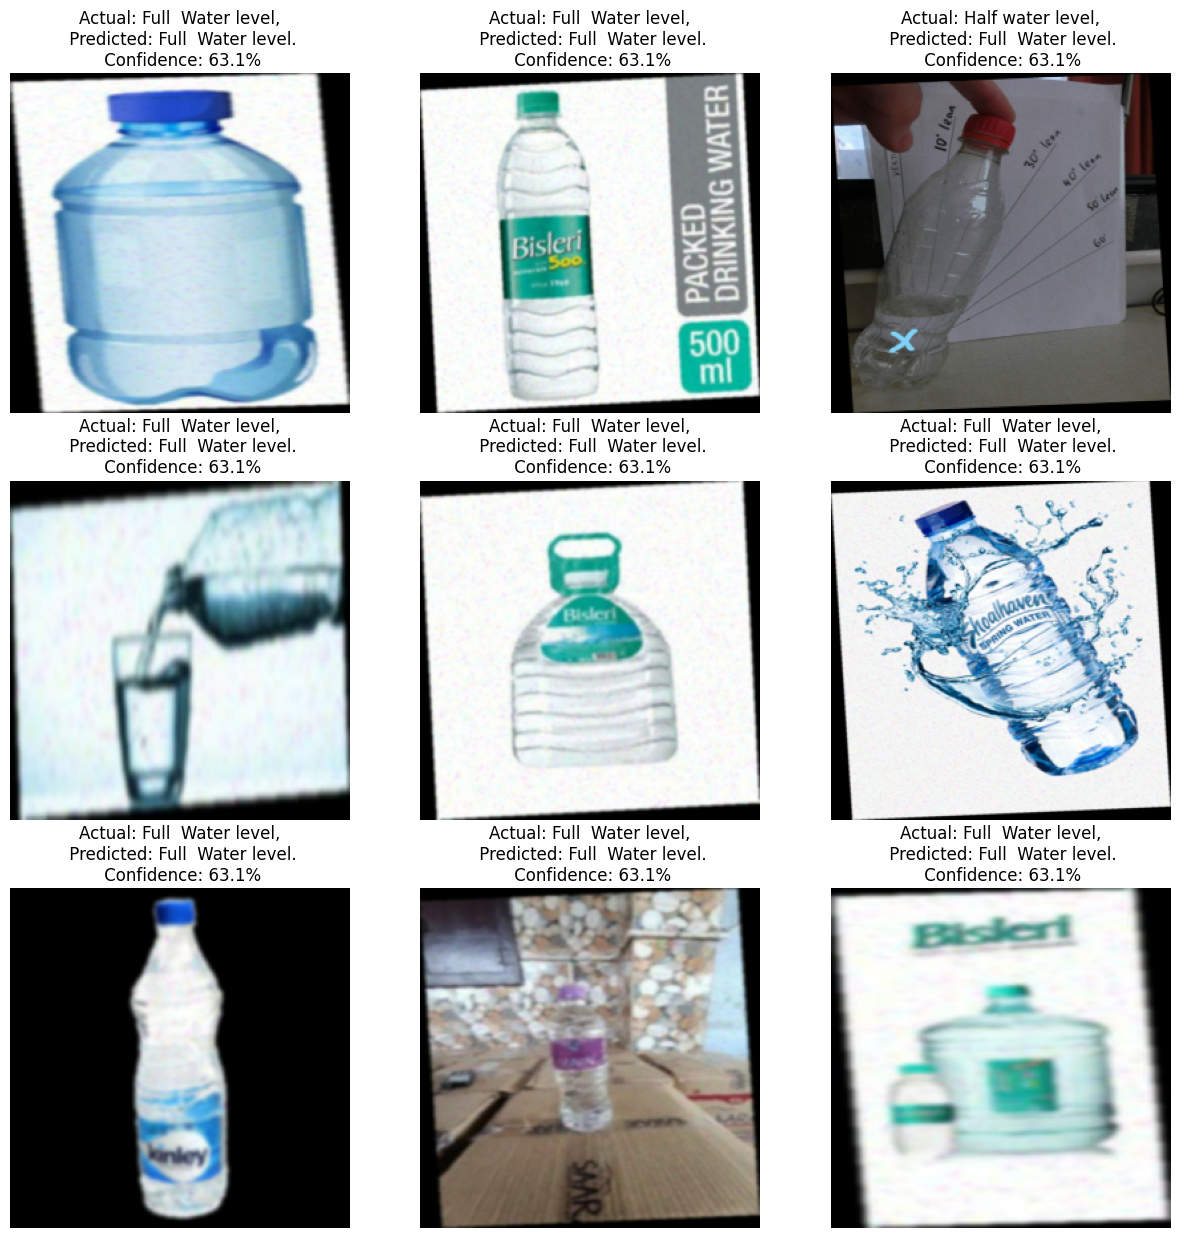

In [59]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

**Run prediction on a sample image**

first image to predict
actual label: Full  Water level
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step


W0000 00:00:1710005174.124341     513 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


predicted label: Full  Water level


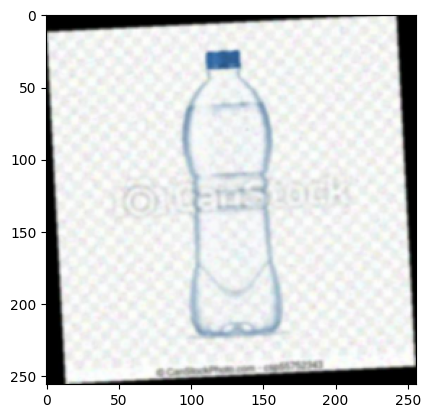

In [60]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**Write a function for inference**

In [61]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


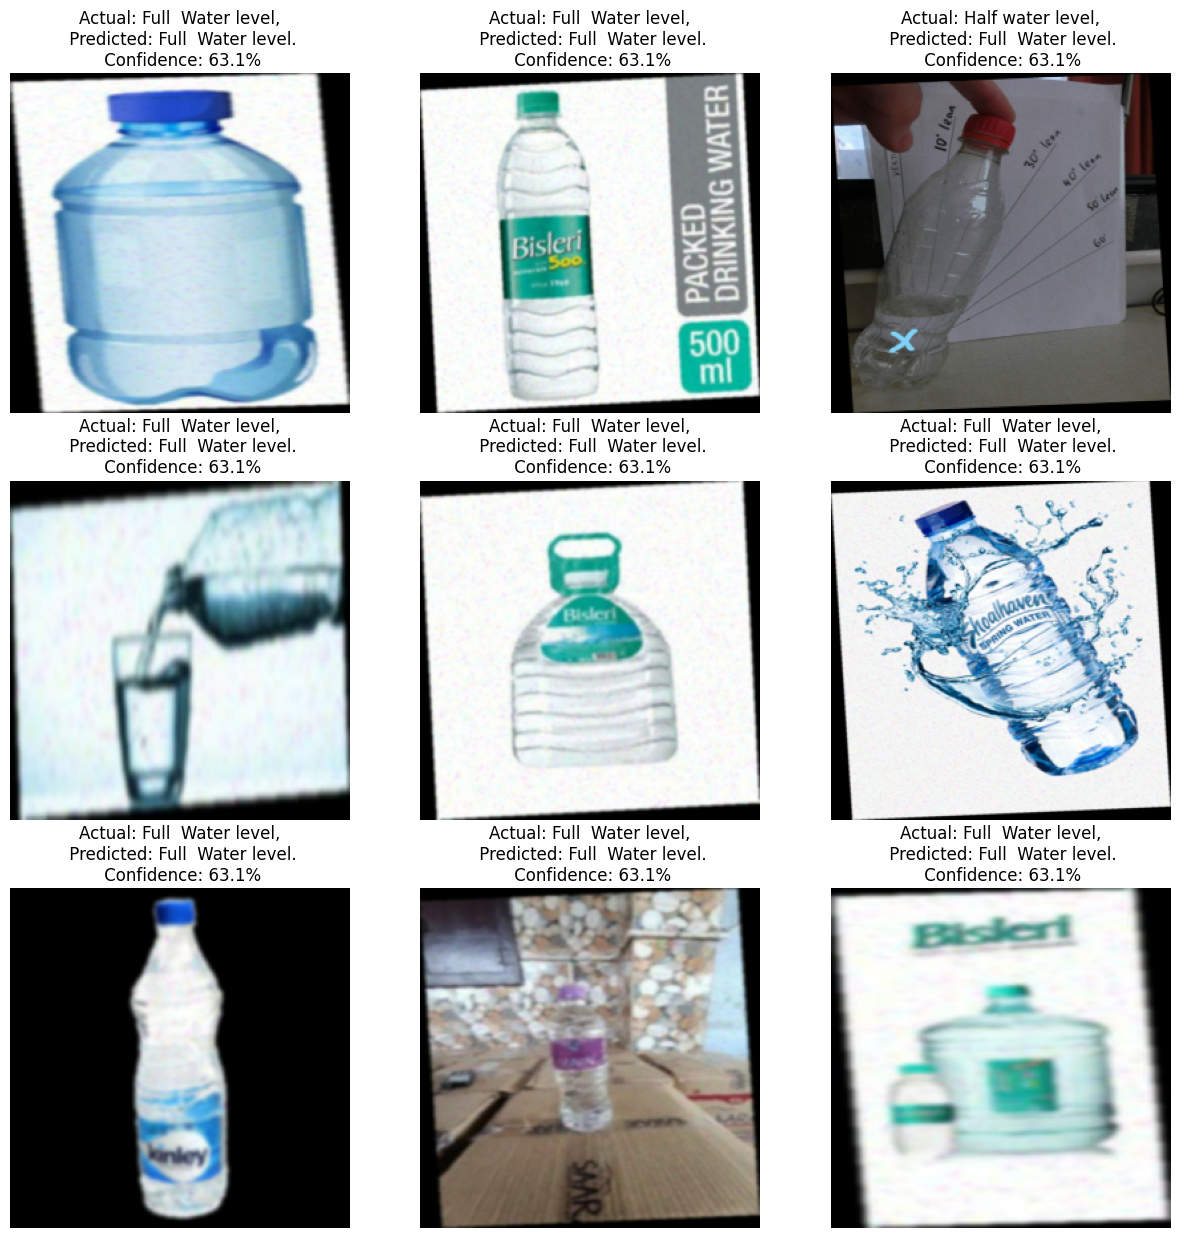

In [62]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")